# Variational Autoencoders

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2022-12-27 16:35:18.315172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 16:35:18.416397: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-27 16:35:18.930708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-27 16:35:18.930780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## MNIST

We will model each pixel with a Bernoulli distribution. Each pixel may take a value either 0 or 1.

In [2]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')


(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


print(train_images.shape, train_images.dtype)
print(test_images.dtype)

(60000, 28, 28, 1) float32
float32


In [3]:
train_size = 60000
batch_size = 32
test_size = 10000

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

2022-12-27 16:35:20.303521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 16:35:20.308228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-27 16:35:20.308246: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-27 16:35:20.308729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

## Encoder

The encoder network approximates the posterior distribution $q(z\mid x)$. It inputs an observation and outputs set of parameters for specifying the conditional distribution of the latent representation of $z$. In this example, we model posterior distribution as a diagonal Gaussian. The network outputs the mean and log-variance parameters of a factorized Gaussian. The log-variance provides numerical stability.

$$
\sigma_{log} = log(\sigma^2) = 2*log(\sigma)
$$

Thus,

$$
\sigma = exp\left(\frac{\sigma_{log}}{2}\right)
$$

## Decoder

The decoder network approximates the conditional distribution $p(x \mid z)$. It inputs a latent variable and outputs the parameters for a conditional distribution of the observation. It models the latent distribution prior $p(z)$ as an unit Gaussian.

## Reparameterization Trick

We could sample $z$ from a Gaussian function but this operation creates a bottleneck because backpropagation cannot flow through a random node. We need a Gaussian function that is independent of variables we wish to backpropagate on. 

We will use a unit Gaussian operation and define $z$ as follows.

$$
z = \mu + \sigma \cdot \epsilon
$$

$\mu$ and $\sigma$ can be derived from the decoder output. The $\epsilon$ is some random noise used to maintain stochasticity of $z$. We get $\epsilon$ fro ma standard unit Gaussian.

## Model

In [5]:
class ConvVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])
    
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return mean + tf.exp(logvar * 0.5) * eps

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Loss

VAE is trained by maximizing the evidence lower bound on the marginal log-likelihood.

$$
log\;p(x) \geq \text{ELBO} = \mathbb{E}_{q(z\mid x)} \left[ log\frac{p(x, z)}{q(z \mid x)} \right]
$$

In practice, optimize the single sample Monte Carlo estimate of this expectation.

$$
log\frac{p(x, z)}{q(z \mid x)} = log\;p(x \mid z) + log\;p(z) - log\;q(z \mid x)
$$

where $z$ is sampled from $q(z \mid x)$.

In [6]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    """Use log to get rid of the exponential in Gaussian"""
    log2pi = tf.math.log(2 * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    log_p_x_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    log_p_z = log_normal_pdf(z, 0., 0.)
    log_q_z_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(log_p_x_z + log_p_z - log_q_z_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Train

In [7]:
epochs = 10
# set the dimensionality of the latent space to a 2D plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = ConvVAE(latent_dim)

print(model.encoder.summary())
print(model.decoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 4)                 9220      
                                                                 
Total params: 28,036
Trainable params: 28,036
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)         

In [8]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [9]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

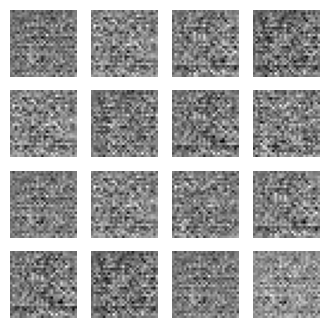

In [10]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -156.0026397705078, time elapse for current epoch: 10.945546627044678


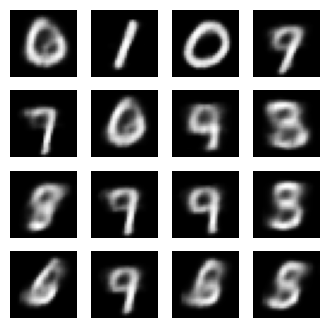

In [11]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

In [12]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

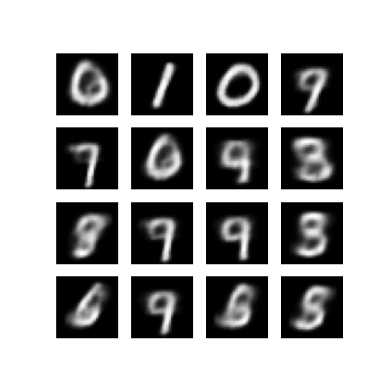

In [13]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

## Visualize Training Progression

In [14]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipykernel_144707/869811583.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_144707/869811583.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



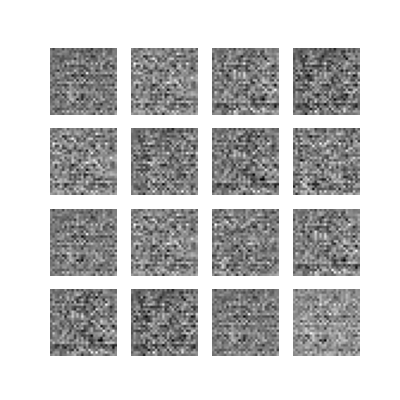

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Visualize Latent Space

We defined our latent dimension to be 2, which means are we can simply visualize the `z` vectors as a 2D image. Now we choose a latent space region. We generate a Gaussian and create `z` vectors from it.

In [18]:
norm = tfp.distributions.Normal(0, 1)
print("Probs of Quantiles", norm.prob(norm.quantile(np.linspace(0., 1., 10))))
print("Probs of Lin Space", norm.prob(np.linspace(0., 1., 10)))

Probs of Quantiles tf.Tensor(
[0.         0.18939508 0.29780126 0.3635998  0.39506775 0.39506775
 0.36359975 0.29780126 0.18939508 0.        ], shape=(10,), dtype=float32)
Probs of Lin Space tf.Tensor(
[0.3989423  0.39648727 0.3892125  0.37738323 0.36142382 0.3418923
 0.31944802 0.29481488 0.26874286 0.24197073], shape=(10,), dtype=float32)


The quantile function returns value of the random variable `X` such that the probability of the variable being less than or equal to that value equals the given probability.

$$
Prob(X \leq value) = p
$$

For example, `norm.quantile(0.1)` is equivalent to say find me the `x` value that has probability of `0.1` that my sample from `norm` will be less than or equal to `x` value.

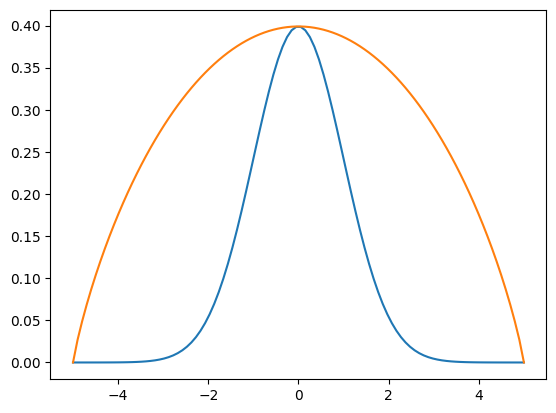

In [19]:
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.prob(x))
plt.plot(x, norm.prob(norm.quantile(np.linspace(0., 1., 100))))

In [21]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))
        
    # Construct a giant image that represent the latent space.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

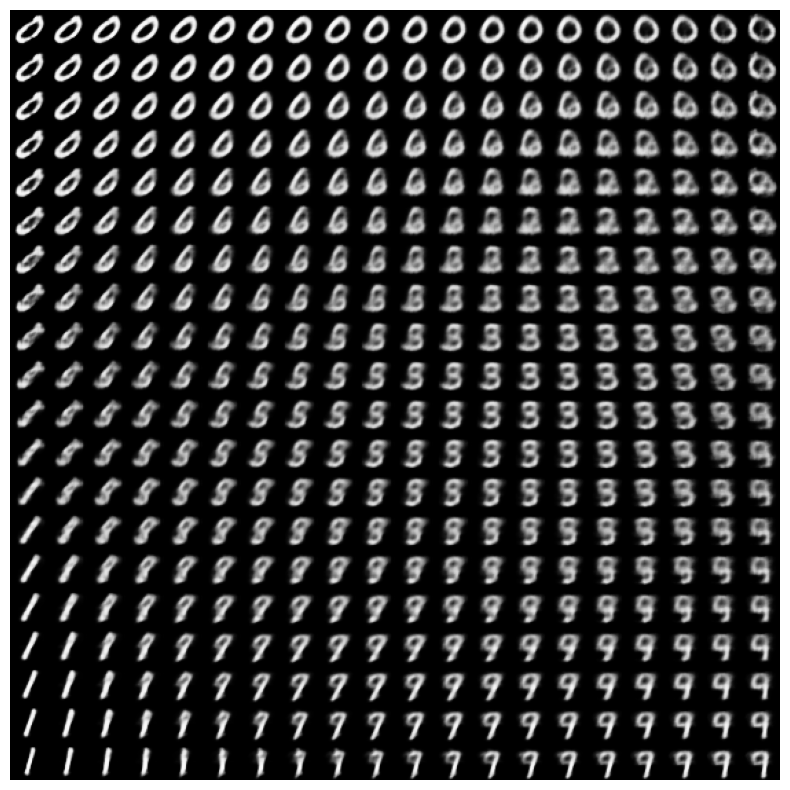

In [22]:
plot_latent_images(model, 20)